#**Realizando a previsão com o modelo Prophet**

##**Conhecendo os dados**

> Você pode checar a documentação da biblioteca Pandas [aqui](https://pandas.pydata.org/).

In [177]:
import pandas as pd
import plotly.express as px
import calendar
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import numpy as np

In [459]:
#leitura dos dados
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', encoding ="utf-8", thousands='.',decimal=',', header = 0)
df = df[2]
df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'y', 'Data': 'ds'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'], dayfirst=True)
df.head()

,ds,y
0,2024-11-18,74.35
1,2024-11-15,73.45
2,2024-11-14,73.39
3,2024-11-13,72.86
4,2024-11-12,72.56


In [180]:
fig = px.line(df, x='ds', y='y')
fig.show()

In [488]:
# Criar um DataFrame com os dados a partir de 2021
df_periodo = df[df['ds'].dt.year > 2021 ]

# Agrupar os dados por mês e calcule a média de do preço
df_periodo_mensal = df_periodo.groupby(df_periodo['ds'].dt.month)['y'].mean().reset_index()

# Adicionar uma coluna com os nomes dos meses
df_periodo_mensal['Mês'] = df_periodo_mensal['ds'].apply(lambda x: calendar.month_abbr[x])

# Criar um gráfico de barras
fig = px.bar(df_periodo_mensal, x='Mês', y='y', title='Média de preço por mês no período')

# Mostrar o gráfico
fig.show()

##**Realizando uma previsão**

> Você pode checar a documentação da biblioteca Prophet [aqui](https://facebook.github.io/prophet/).

In [489]:
df_prophet = df_periodo

#Preenchendo lacunas temporais
date_range = pd.date_range(start=df_prophet.ds.min(), end=df_prophet.ds.max(), freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns=['ds']

df_prophet = pd.merge(date_range, df_prophet, how='left')
df_prophet['y'] = df_prophet['y'].fillna(method='ffill')

C:\Users\engch\AppData\Local\Temp\ipykernel_18372\693481539.py:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [495]:
df_prophet = df_prophet.head(1037)

In [301]:
# Treinando um modelo sem separar treino e teste

np.random.seed(42)

# Instanciar o modelo Prophet
modelo = Prophet()

# Treinar o modelo
modelo.fit(df_prophet)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=90, freq='D')
previsao = modelo.predict(futuro)

20:50:40 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing


In [302]:
fig = plot_plotly(modelo, previsao)
fig.show()

##**Analisando as componentes da série temporal**

In [190]:
plot_components_plotly(modelo, previsao)

A biblioteca Prophet usa um modelo aditivo que inclui componentes sazonais e de tendência. A equação utilizada pelo Prophet para realizar previsões pode ser representada da seguinte forma:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t$

Onde:

- $ y(t)$ é o valor observado na série temporal no tempo \( t \).
- $ g(t) $ é a componente de tendência que modela mudanças de longo prazo.
- $ s(t) $ é a componente sazonal que modela padrões periódicos ou sazonais.
- $ h(t) $ é a componente de efeito de feriados
- $\epsilon_t$ é o erro aleatório na previsão.

Cada uma dessas componentes é modelada separadamente. A componente de tendência, $ g(t)$, é frequentemente modelada como uma função logística ou polinomial. A componente sazonal, $s(t)$, é modelada usando a análise de Fourier para capturar padrões periódicos. A componente de feriado, $h(t)$, é modelada como um efeito aditivo para cada feriado especificado.

Portanto, a equação completa usada pelo Prophet para realizar previsões é uma soma desses componentes mais o erro aleatório.

> Embora em nosso projeto não tenhamos detalhado a inclusão dos feriados no modelo, é importante ressaltar que essa possibilidade existe.

#**Analisando a performance do modelo**

##**Separando os dados em treino e teste**

In [462]:
divisao = int(len(df_prophet) * 0.8)

treino = df_prophet[:divisao]
teste = df_prophet[divisao:]

In [385]:
# Treinando um modelo separando entre treino e teste

np.random.seed(42)

# Instanciar o modelo Prophet
modelo = Prophet()

# Treinar o modelo
modelo.fit(treino)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=int(len(teste)), freq='D')
previsao = modelo.predict(futuro)

21:12:25 - cmdstanpy - INFO - Chain [1] start processing
21:12:25 - cmdstanpy - INFO - Chain [1] done processing


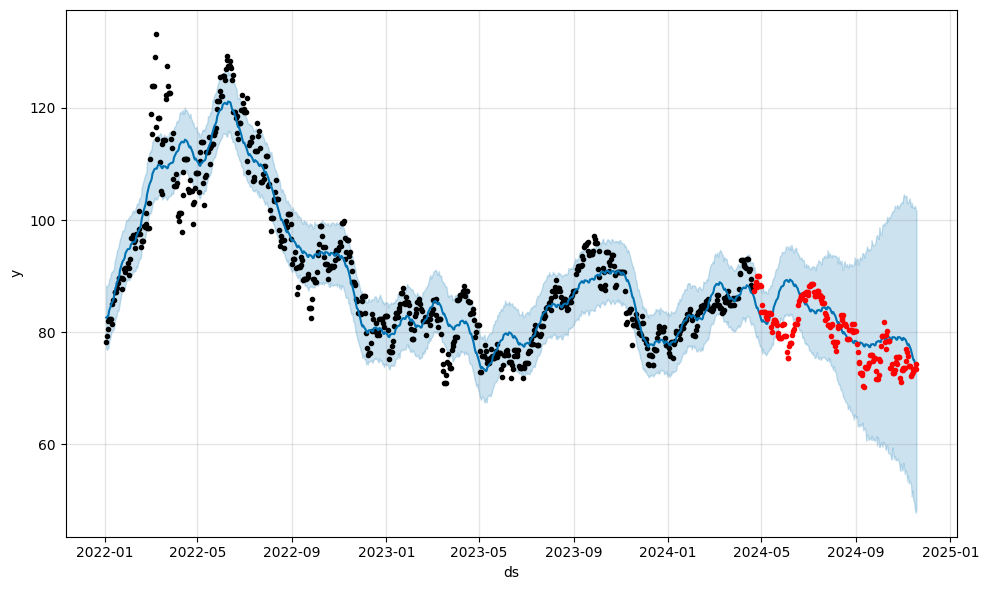

In [386]:
fig1 = modelo.plot(previsao)

plt.plot(teste['ds'], teste['y'], '.r')
plt.show()

##**Obtendo métricas de performance**

In [387]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, teste, on='ds', how='inner')
df_comparacao

,ds,yhat,y
0,2024-04-22,86.017018,87.30
1,2024-04-23,85.426009,88.29
2,2024-04-24,84.788256,89.02
3,2024-04-25,84.349264,88.10
4,2024-04-26,84.390928,89.95
...,...,...,...
206,2024-11-14,75.089699,73.39
207,2024-11-15,75.048080,73.45
208,2024-11-16,74.488332,73.45
209,2024-11-17,73.931583,73.45


A métrica MSE *(Mean Squared Error)* é uma medida comum de avaliação de desempenho para modelos de regressão e previsão. Ela calcula a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados nos dados de teste. Matematicamente, o MSE é calculado pela fórmula:

$MSE = \frac{\sum_{} (y_i - \hat{y}_i)^2}{n}$

No entanto, o MSE tem uma limitação: suas unidades são quadráticas em relação às unidades originais dos dados. Isso pode tornar difícil interpretar o seu valor
Para superar essa limitação, muitas vezes é preferível usar o RMSE *(Root Mean Squared Error)*. O RMSE é simplesmente a raiz quadrada do MSE e é calculado pela fórmula:

$RMSE = \sqrt{MSE}$


In [388]:
# Calculando métricas de erro
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 21.18, RMSE: 4.6


#**Melhorando o modelo**

##**Removendo outliers**

In [496]:
# Definir um seed
np.random.seed(4587)

# Instanciar o modelo Prophet
modelo = Prophet()

# Treinar o modelo
modelo.fit(df_prophet)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=0, freq='D')
previsao = modelo.predict(futuro)

22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:13 - cmdstanpy - INFO - Chain [1] done processing


In [497]:
sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower'])&(df_prophet['y'] < previsao['yhat_upper'])]

In [498]:
sem_outliers

,ds,y
0,2022-01-03,78.25
1,2022-01-04,79.39
2,2022-01-05,80.60
3,2022-01-06,81.99
4,2022-01-07,82.28
...,...,...
1032,2024-10-31,73.25
1033,2024-11-01,73.63
1034,2024-11-02,73.63
1035,2024-11-03,73.63


In [499]:
sem_outliers.reset_index(drop=True, inplace=True)

In [392]:
df_treino_sem_outliers = pd.DataFrame()
df_teste_sem_outliers = pd.DataFrame()

divisao = int(len(sem_outliers) * 0.8)

df_treino_sem_outliers = sem_outliers[:divisao]
df_teste_sem_outliers = sem_outliers[divisao:]

##**Treinando o modelo sem os outliers**

In [393]:
np.random.seed(42)

# Instanciar o modelo Prophet
modelo = Prophet()

# Treinar o modelo
modelo.fit(df_treino_sem_outliers)

# Criar um dataframe para previsões futuras
futuro = modelo.make_future_dataframe(periods=int(len(df_teste_sem_outliers)), freq='D')

# Fazer a previsão
previsao = modelo.predict(futuro)

21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing


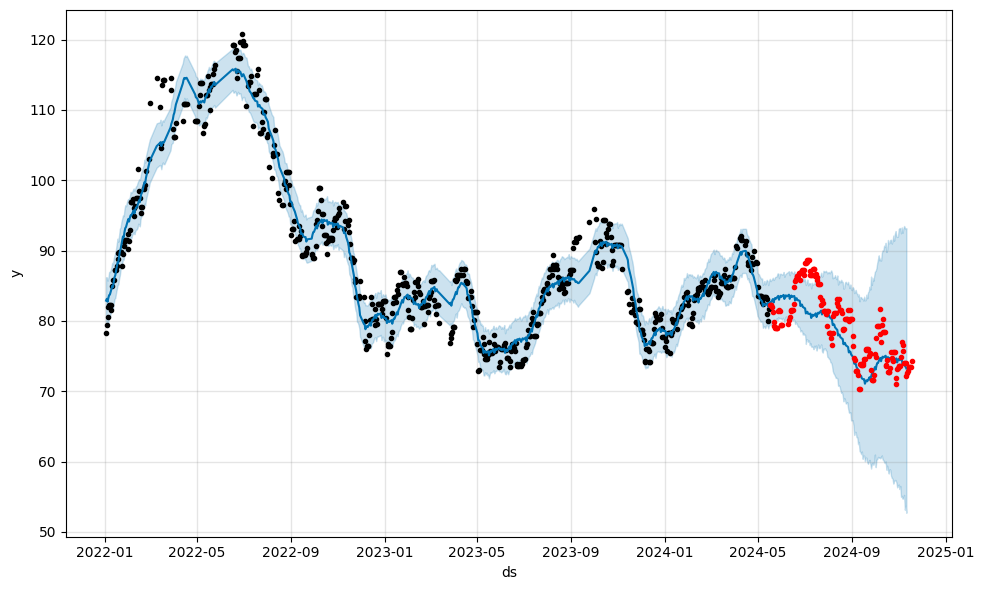

In [394]:
fig1 = modelo.plot(previsao)


plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')

In [395]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao_sem_outliers = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao_sem_outliers, teste, on='ds', how='inner')
df_comparacao

,ds,yhat,y
0,2024-04-22,88.017956,87.30
1,2024-04-23,87.700231,88.29
2,2024-04-24,86.683685,89.02
3,2024-04-25,86.579410,88.10
4,2024-04-26,86.297913,89.95
...,...,...,...
197,2024-11-07,74.036231,75.73
198,2024-11-08,74.025832,74.04
199,2024-11-09,73.629310,74.04
200,2024-11-10,73.465781,74.04


In [396]:
# Calculando métricas de erro
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 12.27, RMSE: 3.5


##**Conhecendo alguns parâmetros do Prophet**

###**`changepoint_prior_scale`**

 `changepoint_prior_scale` é um parâmetro que regula a flexibilidade do modelo em relação à detecção de mudanças de tendência nos dados. O valor padrão deste parâmetro é 0.05, o que oferece um equilíbrio moderado entre sensibilidade e estabilidade nas mudanças de tendência. Se aumentado, o modelo se torna mais sensível a mudanças, identificando mais pontos de mudança, o que pode ser útil em alguns casos. Por outro lado, um valor mais baixo torna o modelo menos flexível, podendo ignorar algumas mudanças reais na tendência dos dados.

###**`yearly_seasonality`**

A	 sazonalidade	 é	 estimada	 usando	 a	 soma	 parcial	 da	Série	 de
Fourier.	 Então,	 o	 número	 de	 termos	 na	 soma	 parcial	 é	 um
parâmetro	que	determina	a	rapidez	com	que	a	sazonalidade	pode
mudar. A	Série	de	Fourier	padrão	para	sazonalidade	anual	é	10. O	valor	padrão	geralmente	é	apropriado,	mas	pode	ser
aumentado quando	a	 sazonalidade	precisa	 se	ajustar	a	alterações
de	frequência	mais	alta	e	geralmente	são	menos	suaves.

##**Ajustando os parâmetros do modelo**

In [480]:
sem_outliers

,ds,y
0,2022-01-03,78.25
1,2022-01-04,79.39
2,2022-01-05,80.60
3,2022-01-06,81.99
4,2022-01-07,82.28
...,...,...
889,2024-11-14,73.39
890,2024-11-15,73.45
891,2024-11-16,73.45
892,2024-11-17,73.45


In [475]:
sem_outliers

,ds,y
15,2022-01-18,88.83
16,2022-01-19,89.64
17,2022-01-20,89.75
18,2022-01-21,89.75
19,2022-01-22,89.75
...,...,...
889,2024-11-14,73.39
890,2024-11-15,73.45
891,2024-11-16,73.45
892,2024-11-17,73.45


In [500]:
# Definir um seed
np.random.seed(42)

# Instanciar o modelo Prophet
modelo_final = Prophet()

# Treinar o modelo
modelo_final.fit(sem_outliers)

# Criar um dataframe para previsões futuras
futuro = modelo_final.make_future_dataframe(periods=0, freq='D')

# Fazer a previsão
previsao = modelo_final.predict(futuro)

22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing


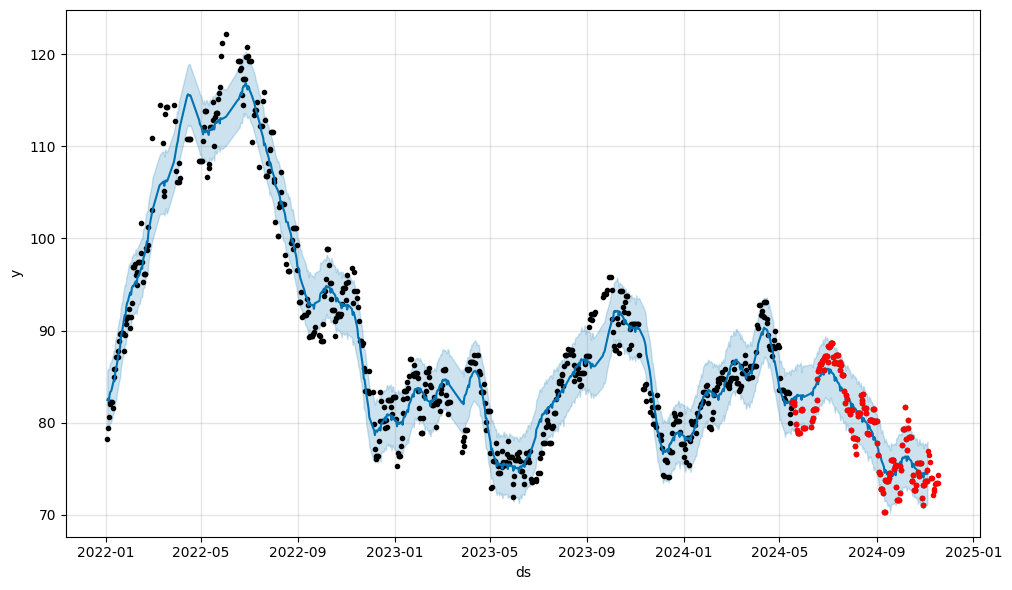

In [501]:
fig1 = modelo_final.plot(previsao)

plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')

In [502]:
# Juntando previsões com o conjunto de teste para comparação
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste_sem_outliers, on='ds', how='inner')


# Calculando o RMSE
rmse = root_mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
print(f'RMSE: {rmse}')

RMSE: 2.21


In [ ]:
fig = plot_components_plotly(modelo, previsao)
fig.show()

#**Aula 4: Validando o modelo**

In [ ]:
df_cv = cross_validation(modelo_final, initial='365.25 days', period='30 days', horizon = '60 days')

##**Analisando métricas**

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [436]:
df_p['rmse'].mean().round(2)

12.36

In [437]:
df_p['mae'].mean().round(2)

9.54

##**Salvando o modelo**

In [503]:
import json

In [504]:
from prophet.serialize import model_to_json

In [505]:
with open('modelo_prophet.json', 'w') as file_out:
    json.dump(model_to_json(modelo_final), file_out)